<a href="https://colab.research.google.com/github/woo2201/0122wndnjs/blob/main/LendingClub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Libraries for exploring, handling and visualizing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob, os
# import dask.dataframe as dd
# from dask.diagnostics import ProgressBar 

import csv
from io import TextIOWrapper
from zipfile import ZipFile
import gzip

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [ ]:
cd /content/drive/MyDrive/dataset/LendingClub/

In [ ]:
path = "/content/drive/MyDrive/dataset/LendingClub/"
filenames = glob.glob(path + "*.csv.gz")
data = [var.split('.')[0].split('/')[-1] for var in filenames]

# dynamically allocate df names.
df_list = []
for name in zip(filenames, data):
    loc = list(name)[0]
    vld = list(name)[1]
    with gzip.open(loc) as f:
        df_list.append(vld)
        globals()[vld] = pd.read_csv(loc, compression='gzip', low_memory= False) # 어차피 gzip 으로 푸는건 blocksize 지정이 안댐

In [ ]:
df_list

In [ ]:
# Accepted 파트의 사이즈와 id 의 숫자
print(accepted_2007_to_2018Q4.shape)
print(rejected_2007_to_2018Q4.shape)
print(accepted_2007_to_2018Q4.id.nunique())

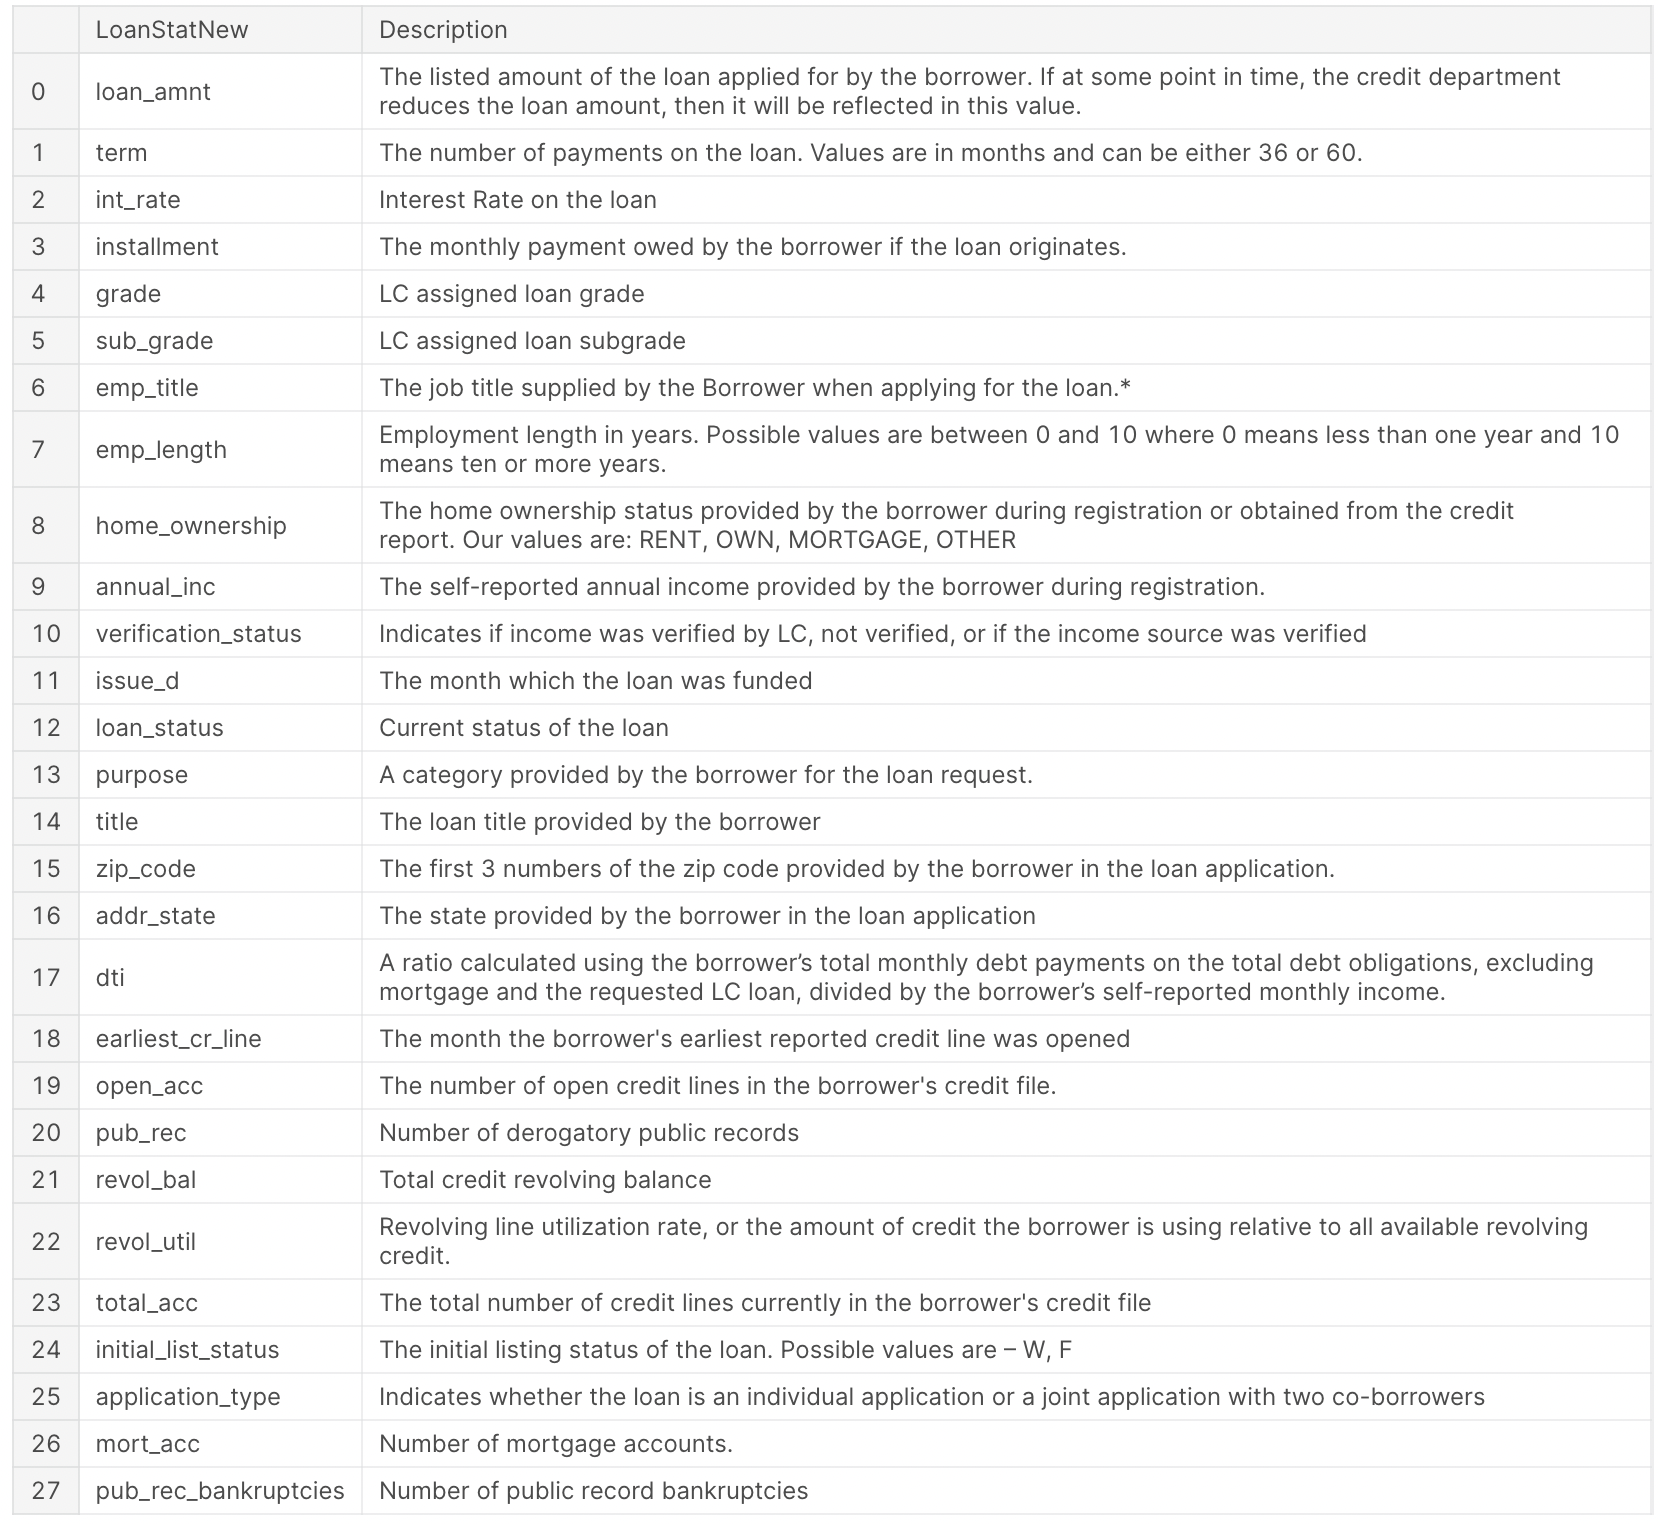

#### My goal is to predict whether one falls into a delinquency within a year, indicating the probability of doing so with an index on scale of 0 to 1000. The second goal is to predict upper boundary of FICO score based on the few columns that are strongly correlated.

Data PreProcessing

    Section Goals:

    Remove or fill any missing data.
    Remove unnecessary or repetitive features.
    Convert categorical string features to dummy variables.

In [ ]:
# 코멘터리가 있는 데이터에 대해서만 사용하기로 한다.
cols_to_select = ['id','loan_amnt','term','int_rate','installment','grade','sub_grade',
                  'emp_title','emp_length', 'home_ownership', 'annual_inc', 'verification_status',
                  'issue_d', 'loan_status', 'purpose', 'title', 'dti', 'earliest_cr_line','open_acc',
                  'pub_rec', 'revol_bal','revol_util', 'total_acc','initial_list_status','application_type',
                  'mort_acc','pub_rec_bankruptcies']

# since maximum loan payoff period is 60 months, equivalent of 5 years. so we use last 5 years data only.
train_dataset = accepted_2007_to_2018Q4[cols_to_select][accepted_2007_to_2018Q4.issue_d.astype("datetime64").dt.year >= 2013]

In [ ]:
target = train_dataset['loan_status']

In [ ]:
def null_count(dataframe):

    if isinstance(dataframe, pd.DataFrame):
        for column in dataframe.columns:
            if (dataframe[column].isna().sum() != 0) | (dataframe[column].isnull().sum() != 0):
                missing = dataframe[column].isna().sum()
                portion = (missing / dataframe.shape[0]) * 100
                print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

    else: 
        print("Not adequate form of dataframe. Check whether it is Pandas DataFrame or not ...")

In [ ]:
null_count(train_dataset)

In [ ]:
for column in train_dataset.columns:
    if train_dataset[column].dtype.kind == 'O':
        print(f"'{column}' : number of unique values ==> '{train_dataset[column].nunique()}'")

In [ ]:
# train_dataset.emp_title.nunique() ; 458,126 .. -> no reason for using this then.
train_dataset.drop(['emp_title', 'title', 'grade'], axis = 1, inplace = True)

In [ ]:
# date columns should be modified too 
train_dataset['earliest_cr_line'] = (train_dataset.issue_d.astype('datetime64') - train_dataset.earliest_cr_line.astype('datetime64')).dt.days
train_dataset['issue_d'] = train_dataset.issue_d.astype('datetime64').apply(lambda x: x.strftime("%Y%m")).rank(method='max')
train_dataset['emp_length'] = train_dataset['emp_length'].fillna('0 year')

In [ ]:
train_dataset.dtypes

In [ ]:
train_id = train_dataset['id']

train_object = train_dataset.select_dtypes(include = ['object']).drop(['id'], axis = 1)
train_numeric = train_dataset.select_dtypes(include = ['float64'])

In [ ]:
# knn imputation

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
train_numeric = imputer.fit_transform(train_numeric) # takes 9 min

In [ ]:
train_numeric = pd.DataFrame(train_numeric,  columns = train_dataset.select_dtypes(include = ['float64']).columns.values)

In [ ]:
col_object = train_object.columns.values
train_object = pd.get_dummies(train_object, columns = col_object)

In [ ]:
train_dataset_complete = pd.concat([train_object, train_numeric], axis = 1)

In [ ]:
train_dataset_complete.drop([i for i in train_dataset_complete.columns.values if i.startswith('loan_status')], axis = 1, inplace = True)

In [ ]:
target.value_counts()

In [ ]:
train_dataset_complete['target'] = target

In [ ]:
def target_convert(x):
    if   x == 'Fully Paid'          : return 0
    elif x == 'Current'             : return 2
    elif x == 'Charged Off'         : return 1
    elif x == 'Late (31-120 days)'  : return 1
    elif x == 'Late (16-30 days)'   : return 1
    elif x == 'In Grace Period'     : return 1
    elif x == 'Default'             : return 1
    else                            : return 2

func          = np.vectorize(target_convert)
target_binary = func(train_dataset_complete['target'])

In [ ]:
train_dataset_complete['target'] = target_binary

In [ ]:
train_df = train_dataset_complete[train_dataset_complete['target'] != 2].dropna(axis=0, how='any')
test_df = train_dataset_complete[train_dataset_complete['target'] == 2].drop(['target'], axis = 1).dropna(axis=0, how='any')

In [ ]:
print(train_df.shape)
print(test_df.shape)

In [ ]:
train_df.target.value_counts()

In [ ]:
y_train = train_df['target']
x_train = train_df.drop(['target'], axis = 1)

In [ ]:
def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):

    import tensorflow as tf
    input = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(input)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=input, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [ ]:
num_columns = x_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 0.05


model = nn_model(
    num_columns = x_train.shape[1], 
    num_labels = num_labels,
    hidden_units = hidden_units,
    dropout_rates = dropout_rates,
    learning_rate = learning_rate
)
r = model.fit(
    x_train, y_train,
    epochs = 30,
    batch_size = 64
)